# Setting up a relative binding free energy network

This tutorial gives a step-by-step process to set up a relative binding free energy (RBFE) simulation campaign using OpenFE. This tutorial is designed as an accompaniment to the CLI tutorial found in the same directory as this notebook.

With the CLI, all the steps here were performed by the `openfe plan-rhfe-network` command. However, that command offers little room for customization. Using the Python interface gives us the ability to customize all aspects of how our simulation runs.

In [1]:
%matplotlib inline
import openfe

## Loading the ligands

First we must load the chemical models between which we wish to calculate free energies.
In this example these are initially stored in a molfile (`.sdf`) containing multiple molecules.
This can be loaded using the `SDMolSupplier` class from rdkit and passed to openfe.

In [2]:
from rdkit import Chem
supp = Chem.SDMolSupplier("tyk2_ligands.sdf", removeHs=False)
ligands = [openfe.SmallMoleculeComponent.from_rdkit(mol) for mol in supp]

## Creating the `LigandNetwork`

The first step is to create a `LigandNetwork`, which is a network with small molecules as nodes, and atom mappings, the description of how to alchemically mutate between the molecules, as its edges.

The pipeline for creating a `LigandNetwork` can involve three components:

* **Atom Mapper**: Proposes potential atom mappings (descriptions of the alchemical change) for pairs of ligands. We will use the `LomapAtomMapper`.
* **Scorer**: Given an atom mapping, provides an estimate of the quality of that mapping (lower scores are better). We will use `default_lomap_scorer`.
* **Network Planner**: Creates the actual `LigandNetwork`; different network planners provide different strategies. We will create a minimal spanning network with the `generate_minimal_spanning_network` method.

Each of these components could be replaced by other options.

In [3]:
mapper = openfe.LomapAtomMapper(max3d=1.0, element_change=False)
scorer = openfe.lomap_scorers.default_lomap_score
network_planner = openfe.ligand_network_planning.generate_minimal_spanning_network

The exact call signature depends on the network planner: a minimal spanning network requires a score, whereas that is optional for a radial network (but a radial network needs the central ligand to be provided).

In [4]:
ligand_network = network_planner(
    ligands=ligands,
    mappers=[mapper],
    scorer=scorer
)

 18%|#7        | 8/45 [00:01<00:07,  5.20it/s]

Now we can look at the overall structure of the `LigandNetwork`:

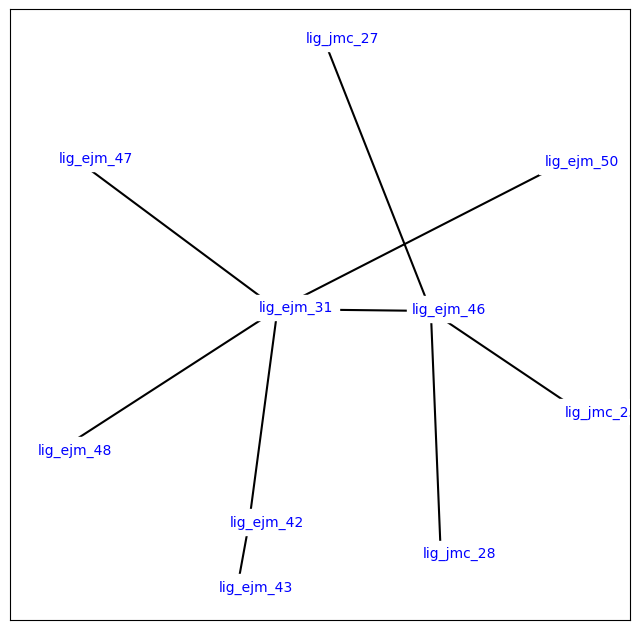

In [5]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

We can also inspect the individual atom mappings:

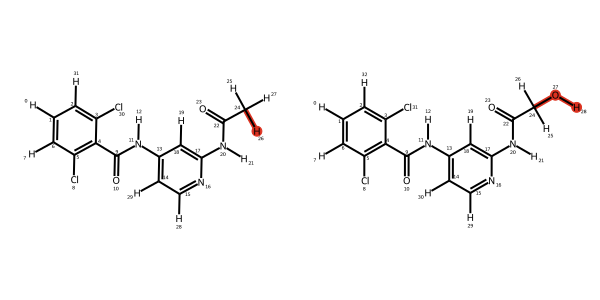

In [6]:
# get the first edge; it automatically displays in a Jupyter notebook
mapping = next(iter(ligand_network.edges))
mapping

You can output this to the same `graphml` format as we saw in the CLI tutorial with the following:

In [7]:
with open("ligand_network.graphml", mode='w') as f:
    f.write(ligand_network.to_graphml())

## Creating a single `Transformation`

The `LigandNetwork` only knows about the small molecules and the alchemical connections between them. It doesn't know anything about environment (e.g., solvent) or about the `Protocol` that will be used during the simulation.

That information in included in a `Transformation`. Each of these transformations corresponds to a single leg of the simulation campaign, so for each edge in the `LigandNetwork`, we will create two `Transformation`s: one for vacuum and one for solvent.

In practice, this will be done for each edge of the `LigandNetwork` in a loop, but for illustrative purposes we'll dive into the details of creating a single transformation. In particular, we'll create the solvent leg for the pair of molecules we selecting for the mapping above.

TODO: SWITCH TO PROTEIN COMPLEX LEG

### Creating `ChemicalSystem`s

OpenFE describes complex molecular systems as being composed of `Component`s. For example, we have `SmallMoleculeComponent` for each small molecule in the `LigandNetwork`. We'll create a `SolventComponent` to describe the solvent, and binding free energy calculations involve a `ProteinComponent`.

The `Component`s are joined in a `ChemicalSystem`, which describes all the particles in the simulation.

In [8]:
# defaults are water with NaCl at 0.15 M
solvent = openfe.SolventComponent()

In [9]:
protein = openfe.ProteinComponent.from_pdb_file("./tyk2_protein.pdb")

In [10]:
systemA = openfe.ChemicalSystem({
    'ligand': mapping.componentA,
    'solvent': solvent,
    'protein': protein
})
systemB = openfe.ChemicalSystem({
    'ligand': mapping.componentB,
    'solvent': solvent,
    'protein': protein    
})

### Creating a `Protocol`

The actual simulation is performed by a `Protocol`. We'll use an OpenMM-based hybrid topology relative free energy `Protocol`.

In [11]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol

The easiest way to customize protocol settings is to start with the default settings, and modify them. Many settings carry units with them.

In [12]:
settings = RelativeHybridTopologyProtocol.default_settings()
settings.thermo_settings.temperature  # display default value

298.15 <Unit('kelvin')>

In [13]:
from openff.units import unit

# change the value
settings.thermo_settings.temperature = 310.0 * unit.kelvin

We'll use the default settings for the protocol we'll use later, to match the behavior of the CLI.

In [14]:
default_settings = RelativeHybridTopologyProtocol.default_settings()
protocol = RelativeHybridTopologyProtocol(default_settings)

### Creating the `Transformation`

Once we have the mapping, the two `ChemicalSystem`s, and the `Protocol`, creating the `Transformation` is easy:

In [15]:
transformation = openfe.Transformation(
    systemA,
    systemB,
    protocol,
    mapping={'ligand': mapping},
)

To summarize, this `Transformation` contains:
- chemical models of both sides of the alchemical transformation in `systemA` and `systemB`
- the correspondence of items in these two sides in `mapping` 
- a description of the exact computational algorithm to use to perform the estimate in `protocol`

## Creating the `AlchemicalNetwork`

The `AlchemicalNetwork` contains all the information needed to run the entire campaign. It consists of a `Transformation` for each leg of the campaign. We'll loop over all the mappings, and then loop over the legs. In that inner loop, we'll make each transformation.

In [16]:
transformations = []
for mapping in ligand_network.edges:
    for leg in ['solvent', 'complex']:
        # use the solvent and protein created above
        sysA_dict = {'ligand': mapping.componentA,
                     'solvent': solvent}
        sysB_dict = {'ligand': mapping.componentB,
                     'solvent': solvent}
        
        if leg == 'complex':
            sysA_dict['protein'] = protein
            sysB_dict['protein'] = protein
        
        # we don't have to name objects, but it can make things (like filenames) more convenient
        sysA = openfe.ChemicalSystem(sysA_dict, name=f"{mapping.componentA.name}_{leg}")
        sysB = openfe.ChemicalSystem(sysB_dict, name=f"{mapping.componentB.name}_{leg}")
        
        prefix = "easy_rbfe_"  # prefix is only to exactly reproduce CLI
        
        transformation = openfe.Transformation(
            stateA=sysA,
            stateB=sysB,
            mapping={'ligand': mapping},
            protocol=protocol,  # use protocol created above
            name=f"{prefix}{sysA.name}_{sysB.name}"
        )
        transformations.append(transformation)

network = openfe.AlchemicalNetwork(transformations)

## Writing the `AlchemicalNetwork` to disk

We'll write out each transformation to disk, so that they can be run independently using the `openfe quickrun` command:

In [17]:
import pathlib
# first we create the directory
transformation_dir = pathlib.Path("transformations")
transformation_dir.mkdir(exist_ok=True)

# then we write out each transformation
for transformation in network.edges:
    transformation.dump(transformation_dir / f"{transformation.name}.json")

In [18]:
!ls transformations/

easy_rbfe_lig_ejm_31_complex_lig_ejm_42_complex.json
easy_rbfe_lig_ejm_31_complex_lig_ejm_46_complex.json
easy_rbfe_lig_ejm_31_complex_lig_ejm_47_complex.json
easy_rbfe_lig_ejm_31_complex_lig_ejm_48_complex.json
easy_rbfe_lig_ejm_31_complex_lig_ejm_50_complex.json
easy_rbfe_lig_ejm_31_solvent_lig_ejm_42_solvent.json
easy_rbfe_lig_ejm_31_solvent_lig_ejm_46_solvent.json
easy_rbfe_lig_ejm_31_solvent_lig_ejm_47_solvent.json
easy_rbfe_lig_ejm_31_solvent_lig_ejm_48_solvent.json
easy_rbfe_lig_ejm_31_solvent_lig_ejm_50_solvent.json
easy_rbfe_lig_ejm_42_complex_lig_ejm_43_complex.json
easy_rbfe_lig_ejm_42_solvent_lig_ejm_43_solvent.json
easy_rbfe_lig_ejm_46_complex_lig_jmc_23_complex.json
easy_rbfe_lig_ejm_46_complex_lig_jmc_27_complex.json
easy_rbfe_lig_ejm_46_complex_lig_jmc_28_complex.json
easy_rbfe_lig_ejm_46_solvent_lig_jmc_23_solvent.json
easy_rbfe_lig_ejm_46_solvent_lig_jmc_27_solvent.json
easy_rbfe_lig_ejm_46_solvent_lig_jmc_28_solvent.json


Each of these individual `.json` files contains a `Transformation`, which contains all the information to run the calculation.  These could be farmed out as individual jobs on a HPC cluster.